In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import os
import shutil

In [13]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams["xtick.minor.visible"] = True 
plt.rcParams["ytick.minor.visible"] = True 

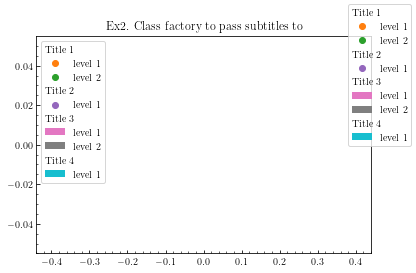

In [14]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase, update_from_first_child

def subtitle_handler_factory(inherit_from):
    """Class factory to subclass Handlers and add our custom functionality
    """
    class SubtitleHandler(inherit_from):
        def legend_artist(self, legend, orig_handle, fontsize, handlebox):
            handlebox.set_visible(False)
            return inherit_from.legend_artist(self, legend,
                                              orig_handle, fontsize,
                                              handlebox)
    
    #HandlerPatch class needs a special unpdate_func
    if inherit_from is matplotlib.legend_handler.HandlerPatch:
        return SubtitleHandler(update_func=update_from_first_child)
    return SubtitleHandler()

def subtitle_handler_map(subtitles):
    defaults_handler_map = Legend.get_default_handler_map()
    handler_map = {}
    
    for orig_handle in subtitles:
        handler = Legend.get_legend_handler(defaults_handler_map, orig_handle)
        
        #Subclass the Handler
        new_handler = subtitle_handler_factory(type(handler))
        handler_map[orig_handle] = new_handler
    return handler_map

def mpl_new_default_handler_map():
    f, ax = plt.subplots()

    h1 = ax.scatter([],[], label="Title 1")
    h2 = ax.scatter([],[], label="level 1")
    h3 = ax.scatter([],[], label="level 2")
    h4 = ax.scatter([],[], label="Title 2")
    h5 = ax.scatter([],[], label="level 1")

    h6 = ax.bar(0,0, label="Title 3")
    h7 = ax.bar(0,0, label="level 1")
    h8 = ax.bar(0,0, label="level 2")
    h9 = ax.bar(0,0, label="Title 4")
    h10 = ax.bar(0,0, label="level 1")

    subtitles = [h1, h4, h6, h9]
    handler_map = subtitle_handler_map(subtitles)
    
    ax.set_title("Ex2. Class factory to pass subtitles to")
    ax_legend = ax.legend(loc="upper left", handler_map=handler_map)
    fig_legend = f.legend(handler_map=handler_map)
    
    plt.show()

mpl_new_default_handler_map()

In [4]:
#Data Operations

####################################################################################
# Data from Files
def GetData1(filename):
    data = np.loadtxt(filename, comments='#')
    x = data[:,0]
    y = data[:,3]
    err = data[:,4]
    xstep = np.append(data[:,1],data[-1,2])
    ystep = np.append(data[:,3],data[-1,3])

    return x, y, err, xstep, ystep

def GetData2(filename1,filename2):
    x1, y1, err1, xstep1, ystep1 = GetData1(filename1)
    x2, y2, err2, xstep2, ystep2 = GetData1(filename2)
    x = x1
    y = 0.5*(y1+y2)
    err = 0.5*np.sqrt(err1*err1+err2*err2)
    xstep = xstep1
    ystep = 0.5*(ystep1+ystep2)
    return x, y, err, xstep, ystep

def GetExpData(filename):
    data = np.loadtxt(filename, comments='#')
    x = data[:,0]
    y = data[:,3]
    err = data[:,4]
    xstep = np.append(data[:,1],data[-1,2])
    ystep = np.append(data[:,3],data[-1,3])
    sysp = np.append(data[:,6],data[-1,6])
    sysm = -sysp
    #print(len(data[0,:]))
    if len(data[0,:]) > 7:
        sysm = np.append(data[:,7],data[-1,7])
    return x, y, err, xstep, ystep, sysp, sysm

def GetDataRatio(x1, y1, err1, xstep1, ystep1, x2, y2, err2, xstep2, ystep2):
    x = x1
    y, err = RatioError(y1, err1, y2, err2)
    xstep = xstep1
    ystep = ystep1/ystep2
    return x, y, err, xstep, ystep

####################################################################################
# Errors
def RatioError(y1, err1, y2, err2):
    return y1/y2, np.sqrt( (err1/y2)*(err1/y2) + (y1*err2/y2/y2)*(y1*err2/y2/y2) )

def ProdError(y1, err1, y2, err2):
    return y1*y2, np.sqrt( y2*y2*err1*err1 + y1*y1*err2*err2 )

def SumError(y1, err1, y2, err2, pm=1.):
    return y1 + pm*y2, np.sqrt( err1*err1 + err2*err2 )
####################################################################################
# Integration
def GetData1Integrate(filename,bin=0):
    data = np.loadtxt(filename, comments='#')
    x = data[:,0]

    dx = 1.0
    if bin == 1:
      dx = data[:,2] - data[:,1]
    
    y = data[:,3]*dx
    err = data[:,4]*dx
    err2 = err*err

    for i in range(1,len(y)):
      y[i]=y[i-1]+y[i]
      err2[i]=err2[i-1]+err2[i]

    xstep = np.append(data[:,1],data[-1,2])
    ystep = np.append(y[:],y[-1])
    err = np.sqrt(err2)

    return x, y, err, xstep, ystep

In [15]:
def CombineLast2Bins(x, y, err, xstep, ystep):
  ###############
  # Bin
  xstep[-2] = xstep[-1]
  x[-2] = 0.5*(x[-2]+x[-1])
  y[-2], err[-2] = SumError(y[-2], err[-2], y[-1], err[-1])
  y[-2] = 0.5*y[-2]
  err[-2] = 0.5*err[-2]
  #####
  ystep[-3] = 0.5*(ystep[-3]+ystep[-2])
  ystep[-2] = ystep[-3]
  #####
  x = x[:-1]
  y = y[:-1]
  err = err[:-1]
  xstep = xstep[:-1]
  ystep = ystep[:-1]
  ###############
  return x, y, err, xstep, ystep


In [16]:
def SetOutputData(x, y, err, xstep, ystep):
  data = np.zeros((len(x),7))
  data[:,0]=x
  data[:,1]=xstep[:-1]
  data[:,2]=xstep[1:]  
  data[:,3]=y  
  data[:,4]=err  
  return data

def OutputData(file_name, x, y, err, xstep, ystep):
  data = SetOutputData(x, y, err, xstep, ystep)
  np.savetxt(file_name,data) 

In [17]:
yamlFile = '/Users/yasukitachibana/GoogleDrive/Codes/JetAnalysis/config/ExtraPythonScripts/SD_ATLAS.yaml'
dataDir = '/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS'

import yaml

with open(yamlFile, 'r') as ymlf:
  yaml_data_list = yaml.safe_load(ymlf)

target_file_name = yaml_data_list['target_file_name']
rg_bin_finest = yaml_data_list['rg_bin_finest']
rg_bin_combine = yaml_data_list['rg_bin_combine']
pt_bin_finest = yaml_data_list['pt_bin_finest']
pt_bin_combine = yaml_data_list['pt_bin_combine']
main_results_tail = yaml_data_list['main_results_tail']
pt_rg_2d_filename = yaml_data_list['pt_rg_2d_filename']
rg_1d_filename = yaml_data_list['rg_1d_filename']
pt_1d_filename = yaml_data_list['pt_1d_filename']

print('Yaml File ', yamlFile)
print('Has Been Read')

Yaml File  /Users/yasukitachibana/GoogleDrive/Codes/JetAnalysis/config/ExtraPythonScripts/SD_ATLAS.yaml
Has Been Read


# PP references

/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/PP/PPMainResults/atlas_rg_pt158-200.txt
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/PP/rg/plot_pp_atlas_rg_pt158-200.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/PP/PPMainResults/atlas_rg_pt200-316.txt
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/PP/rg/plot_pp_atlas_rg_pt200-316.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/PP/PPMainResults/atlas_rg_pt316-501.txt
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/PP/rg/plot_pp_atlas_rg_pt316-501.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/PP/PPMainResults/atlas_rg_pt501-1000.txt
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/Substruct

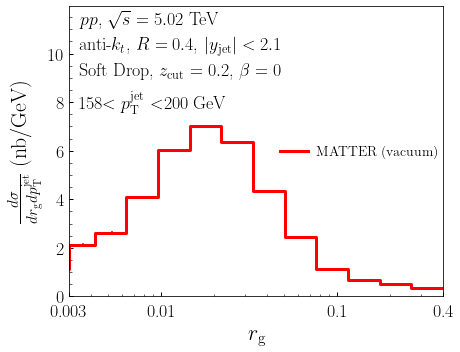

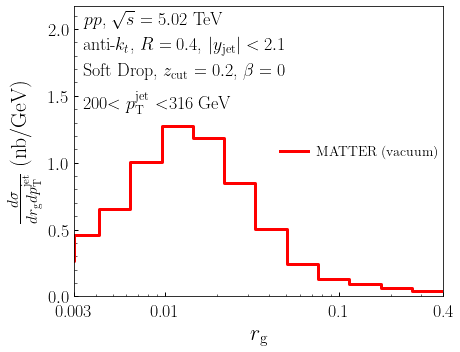

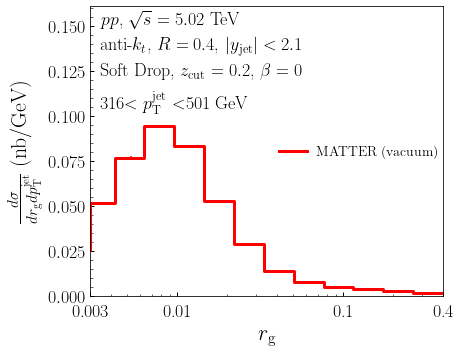

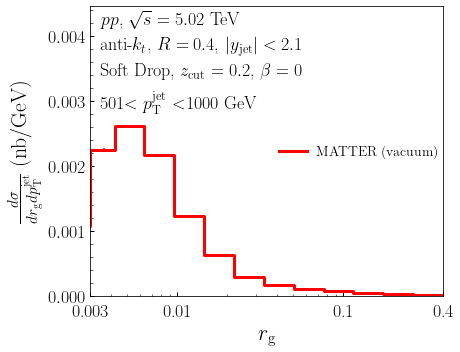

In [40]:
#rg distribution:

dirName = os.path.join(dataDir,'PP')
#dirName = [os.path.join(dirName, 'PPMainResults'), os.path.join(dirName, 'PYTHIAMainResults')]
dirName = [os.path.join(dirName, 'PPMainResults')]
lines = [['red', 'solid'],['blue','dashed']]
labels = ['MATTER (vacuum)','PYTHIA8 (default)']
plot_filename= os.path.join(dataDir,'Plots','PP','rg','plot_pp_'+rg_1d_filename.replace('txt','pdf'))


copy_file_path = ['/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/pp','/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/pythia']
copy_file_path_pdf = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/pp_plot'

#pt_bin_combine_here = [[0,13],[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8],[8,9],[9,10],[10,11],[11,12],[12,13]]
pt_bin_combine_here = [[0,2],[2,6],[6,10],[10,13]]

for k in pt_bin_combine_here:

  # fig, axs = plt.subplots(2, 1, figsize=(5, 6), sharex='col', sharey='row',
  #                       gridspec_kw={'hspace': 0, 'wspace': 0,'height_ratios': (5,3)})
  # axt, axb  = axs

  fig, axs = plt.subplots(1, 1, figsize=(6.5, 5))


  ptl=pt_bin_finest[k[0]]
  pth=pt_bin_finest[k[1]]

  ymax_plot = 0

  
  handles = []
  # Get File name
  for i_data, dir_name in enumerate(dirName):
    filename = os.path.join(dir_name,rg_1d_filename.format(str(int(ptl)),str(int(pth))))
    print(filename)
    x, y, err, xstep, ystep = GetData1(filename)
    axs.step(xstep, ystep, where='post', color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)
    axs.errorbar(x, y, err, marker="", linestyle="none", color=lines[i_data][0])
    tcurve = axs.errorbar(0, 0, color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)
    handles.append(tcurve)

    shutil.copy(filename, copy_file_path[i_data])

    ymax = max(y)
    if ymax_plot < ymax:
      ymax_plot = ymax


  ylim_h = ymax_plot*1.7
  ###############
  axs.tick_params(labelsize = 18, width = 1, length = 4)
  axs.tick_params(labelsize = 18, length = 2.5, which='minor')  
  axs.tick_params(pad=7, axis='x')
  axs.tick_params(pad=7, axis='x', which='minor')  
  axs.tick_params(pad=5, axis='y')    

  axs.set_ylabel(r'$\frac{d\sigma}{d r_{\mathrm{g}} dp_{\mathrm{T}}^{\mathrm{jet}} }$  (nb/GeV)', fontsize=22, labelpad=6)
  axs.set_xlabel(r'$r_{\mathrm{g}}$', fontsize=22, labelpad=6)
  axs.set_xlim(0.003,0.4)
  axs.set_ylim(0,ylim_h)  
  axs.set_xscale('log')
  axs.label_outer()
  axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  axs.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter()) 
  axs.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1g'))
  #axs.get_xaxis().set_minor_formatter(plt.FormatStrFormatter('%.1g'))    
  #axs.set_xticks([0.003,0.01,0.02,0.1,0.2,0.3, 0.4])  
  #axs.set_xticks([0.01,0.1]) 
  axs.set_xticks([0.003,0.01,0.1,0.4])      
  #axs.set_xticks([0.003,0.02,0.2,0.3, 0.4], minor=True)    
  #axs.get_xaxis().get_major_formatter().set_useOffset(False)  

  # ###############
  axs.text(0.0034, ylim_h*0.94, r'$pp$, $\sqrt{s}=5.02$ TeV', fontsize = 18, ha = 'left')
  axs.text(0.0034, ylim_h*0.85, r'anti-$k_t$, $R=0.4$, $|y_{\mathrm{jet}}|<2.1$', fontsize = 18, ha = 'left')  
  axs.text(0.0034, ylim_h*0.76, r'Soft Drop, $z_{\mathrm{cut}}=0.2$, $\beta=0$', fontsize = 18, ha = 'left')    

  axs.text(0.0034, ylim_h*0.65, str(int(ptl))+r'$<p_{\mathrm{T}}^{\mathrm{jet}}<$'+str(int(pth))+' GeV', fontsize = 18, ha = 'left')
  

  axs.legend(handles,labels,ncol=1,loc='lower right',edgecolor='none', frameon=True, facecolor='none', handletextpad=0.6, handleheight=0.5, labelspacing=0.5, bbox_to_anchor=(1.02, 0.43), borderaxespad=0.5, handlelength=2, fontsize=14)


  # Generate PDF File
  pdf_filename = plot_filename.format(str(int(ptl)),str(int(pth)))
  print(pdf_filename)
  plt.tight_layout()
  plt.savefig(pdf_filename,transparent=True)
  shutil.copy(pdf_filename, copy_file_path_pdf)


'/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/pp_plot/pt.pdf'

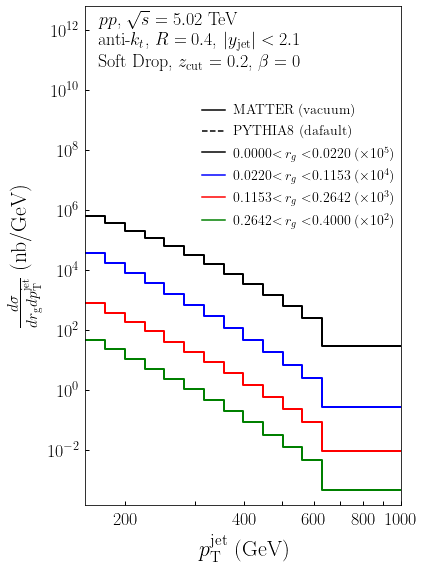

In [41]:
#pt distribution:



dirName = os.path.join(dataDir,'PP')
#dirName = [os.path.join(dirName, 'PPMainResults'), os.path.join(dirName, 'PYTHIAMainResults')]
dirName = [os.path.join(dirName, 'PPMainResults')]


line_style = ['solid','dashed']
line_color = ['black', 'blue', 'red', 'green', 'magenta', 'cyan']
labels = ['MATTER (vacuum)','PYTHIA8 (default)']
label_scale = [r' ($\times 10^5$)',r' ($\times 10^4$)',r' ($\times 10^3$)', r' ($\times 10^2$)','']


copy_file_path = ['/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/pp','/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/pythia']
copy_file_path_pdf = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/pp_plot'


plot_filename= os.path.join(dataDir,'Plots','PP','pt.pdf')
rg_bin_combine_here = [[1,7],[7,11],[11,13],[13,14]]

# plot_filename= os.path.join(dataDir,'Plots','PP','pt_1.pdf')
# rg_bin_combine_here = [[0,14],[0,1],[1,2],[2,3],[3,4]]

# plot_filename= os.path.join(dataDir,'Plots','PP','pt_2.pdf')
# rg_bin_combine_here = [[4,5],[5,6],[6,7],[7,8],[8,9]]

# plot_filename= os.path.join(dataDir,'Plots','PP','pt_3.pdf')
# rg_bin_combine_here = [[9,10],[10,11],[11,12],[12,13],[13,14]]

fig, axs = plt.subplots(1, 1, figsize=(6, 8))


ymax_plot = 0
ymin_plot = 10**100


for i_k, k in enumerate(rg_bin_combine_here):

  rgl=rg_bin_finest[k[0]]
  rgh=rg_bin_finest[k[1]]

  this_bin_label = ''

  if k[0] == 0:
    if k[1] == 1:
      this_bin_label = 'Soft Drop Failure'
    else:
      this_bin_label = 'Inclusive'
  else:
    this_bin_label = '{:.4f}'.format(rgl)+r'$<r_g<$'+'{:.4f}'.format(rgh)


  label_list=[this_bin_label+label_scale[i_k],'']
  for i_data, dir_name in enumerate(dirName):
  # Get File name
    filename = os.path.join(dir_name,pt_1d_filename.format(str(int(10000*rgl)).zfill(4),str(int(10000*rgh)).zfill(4)))

    #print(filename)
    x, y, err, xstep, ystep = GetData1(filename)
    shutil.copy(filename, copy_file_path[i_data])

    
    ystep = ystep*(10**(5-i_k))
    y = y*(10**(5-i_k))    
    err = err*(10**(5-i_k))          

    if i_k == 0 and i_data == 0:
        axs.errorbar(0, 0, color=line_color[i_k],linestyle=line_style[0], label='MATTER (vacuum)')   
        axs.errorbar(0, 0, color=line_color[i_k],linestyle=line_style[1], label='PYTHIA8 (dafault)')           

    axs.step(xstep, ystep, where='post', color=line_color[i_k],linestyle=line_style[i_data], linewidth = 2)
    axs.errorbar(x, y, err, marker="", linestyle="none", color=line_color[i_k])
    axs.errorbar(0, 0, color=line_color[i_k],linestyle=line_style[i_data], label=label_list[i_data])

 
    

    ymax = max(y)
    ymin = min(y)
    if ymax_plot < ymax:
      ymax_plot = ymax
    if ymin_plot > ymin:
      ymin_plot = ymin



ylim_h = ymax_plot*(10**(7))  
ylim_l = ymin_plot*(10**(-0.5))  
###############
axs.tick_params(labelsize = 18, width = 1, length = 4)
axs.tick_params(labelsize = 18, width = 1, length = 4, which='minor',axis='x')  
axs.tick_params(labelsize = 18, length = 2.5, which='minor',axis='y') 

axs.tick_params(pad=7, axis='x')
axs.tick_params(pad=7, axis='x', which='minor')  
axs.tick_params(pad=5, axis='y')    
axs.tick_params(pad=5, axis='y', which='minor')

axs.set_ylabel(r'$\frac{d\sigma}{d r_{\mathrm{g}} dp_{\mathrm{T}}^{\mathrm{jet}} }$  (nb/GeV)', fontsize=22, labelpad=6)
axs.set_xlabel(r'$p_{\mathrm{T}}^{\mathrm{jet}}$ (GeV)', fontsize=22, labelpad=6)
axs.set_xlim(158,1000)
axs.set_ylim(ylim_l,ylim_h) 
axs.set_xscale('log')
axs.set_yscale('log')

axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter()) 
axs.set_xticks([200,400,600,800,1000])
axs.label_outer()

###############
axs.text(170, ylim_h*(10**(-0.6)), r'$pp$, $\sqrt{s}=5.02$ TeV', fontsize = 18, ha = 'left')
axs.text(170, ylim_h*(10**(-1.3)), r'anti-$k_t$, $R=0.4$, $|y_{\mathrm{jet}}|<2.1$', fontsize = 18, ha = 'left')  
axs.text(170, ylim_h*(10**(-2)), r'Soft Drop, $z_{\mathrm{cut}}=0.2$, $\beta=0$', fontsize = 18, ha = 'left')    

#axs.text(500, ylim_h*(10**0.92), str(int(ptl))+r'$<p_{\mathrm{T}}^{\mathrm{jet}}<$'+str(int(pth))+' GeV', fontsize = 18, ha = 'right')
  

axs.legend(ncol=1,loc='lower right',edgecolor='none', frameon=True, facecolor='none', handletextpad=0.6, handleheight=0.5, labelspacing=0.5, bbox_to_anchor=(1.02, 0.53), borderaxespad=0.5, handlelength=1.6, fontsize=14)


#Generate PDF File
plt.tight_layout()
plt.savefig(plot_filename,transparent=True)

shutil.copy(plot_filename, copy_file_path_pdf)  
  

/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_rg_cent0-10.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_rg_cent10-30.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_rg_cent30-50.pdf


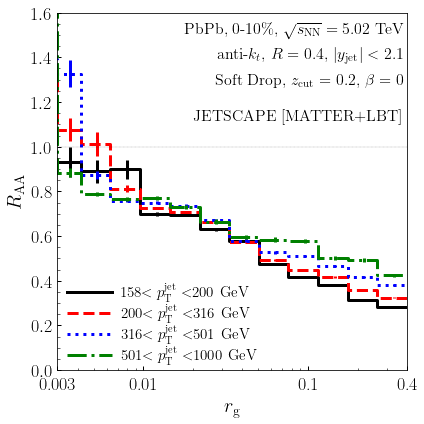

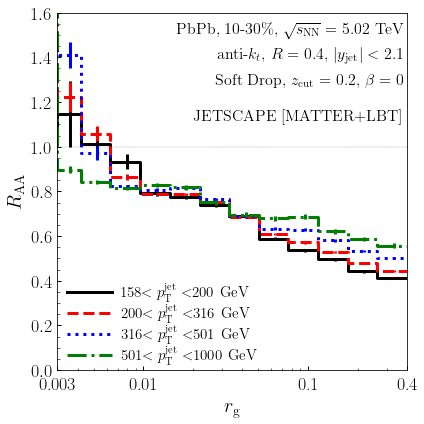

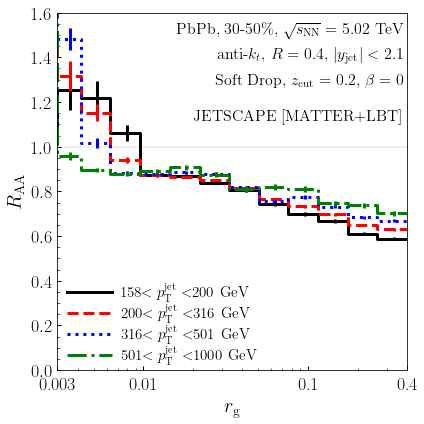

In [42]:
filename_pp = os.path.join(dataDir,'PP','PPMainResults',rg_1d_filename)
filename_aa = os.path.join(dataDir,'Q2QHAT','5020_PbPb_{}-{}_0.30_2.0_1MainResults', rg_1d_filename)
lines = [['black', 'solid'], ['red', 'dashed'],['blue','dotted'],['green','dashdot'],['magenta',(10, (5, 3, 1, 3, 1, 3))]]

copy_file_path = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/pbpb'
copy_file_path_raa = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/raa'
copy_file_path_pdf = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/rg-dist/raa_plot'

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_rg_cent{}-{}.pdf')
# pt_bin_combine_here = [[0,13],[0,2],[2,6],[6,10]]


plot_filename= os.path.join(dataDir,'Plots','plot_raa_rg_cent{}-{}.pdf')
pt_bin_combine_here = [[0,2],[2,6],[6,10],[10,13]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_rg_cent{}-{}_1.pdf')
# pt_bin_combine_here = [[0,13],[0,1],[1,2],[2,3],[3,4]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_rg_cent{}-{}_2.pdf')
# pt_bin_combine_here = [[4,5],[5,6],[6,7],[7,8],[8,9]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_rg_cent{}-{}_3.pdf')
# pt_bin_combine_here = [[9,10],[10,11],[11,12],[12,13]]


cent = [ [['0','5'], ['5','10']], [['10','20'], ['20','30']], [['30','40'], ['40','50']] ] 

for c in cent:
  fig, axs = plt.subplots(1, 1, figsize=(6, 6))
  handles = []
  labels = []
  filename_cent = [] 

  for c_sub in c:
    filename_cent.append(filename_aa.format(c_sub[0], c_sub[1],'{}','{}'))
  
  for i_data, k in enumerate(pt_bin_combine_here):

    ptl=pt_bin_finest[k[0]]
    pth=pt_bin_finest[k[1]]

    ymax_plot = 0

  

    # Get File name

    #PP 
    filename = filename_pp.format(str(int(ptl)),str(int(pth)))
    x_pp, y_pp, err_pp, xstep_pp, ystep_pp = GetData1(filename)

    #AA
    filename = []
    for i_c_sub, c_sub in enumerate(c): 
      filename.append(filename_cent[i_c_sub].format(str(int(ptl)),str(int(pth))))

    x_aa, y_aa, err_aa, xstep_aa, ystep_aa = GetData2(filename[0],filename[1])

    copy_file_name = os.path.join(copy_file_path,'{}-{}'.format(c[0][0],c[-1][1]),os.path.basename(filename[0]))
    OutputData(copy_file_name, x_aa, y_aa, err_aa, xstep_aa, ystep_aa)



    x, y, err, xstep, ystep = GetDataRatio(x_aa, y_aa, err_aa, xstep_aa, ystep_aa, x_pp, y_pp, err_pp, xstep_pp, ystep_pp) 

    copy_file_name_raa = os.path.join(copy_file_path_raa,'{}-{}'.format(c[0][0],c[-1][1]),'raa_'+os.path.basename(filename[0]))
    OutputData(copy_file_name_raa, x, y, err, xstep, ystep)
    



    axs.step(xstep, ystep, where='post', color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)
    axs.errorbar(x, y, err, marker="", linestyle="none", color=lines[i_data][0], linewidth = 3)
    tcurve = axs.errorbar(0, 0, color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)

    labels.append( str(int(ptl))+r'$<p^{\mathrm{jet}}_{\mathrm{T}}<$'+str(int(pth))+' GeV')
    handles.append(tcurve)


    ymax = max(y)
    if ymax_plot < ymax:
      ymax_plot = ymax


  ylim_h = 1.6 #ymax_plot*1.2
  ################
  axs.tick_params(labelsize = 18, width = 1, length = 4)
  axs.tick_params(labelsize = 18, length = 2.5, which='minor')  
  axs.tick_params(pad=7, axis='x')
  axs.tick_params(pad=7, axis='x', which='minor')  
  axs.tick_params(pad=5, axis='y')   


  axs.set_ylabel(r'$R_{\mathrm{AA}}$', fontsize=20, labelpad=6)
  axs.set_xlabel(r'$r_{\mathrm{g}}$', fontsize=20, labelpad=6)
  axs.set_xlim(0.003,0.4)
  axs.set_ylim(0,ylim_h)  
  axs.set_xscale('log')
  




  axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  axs.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter()) 
  axs.get_xaxis().set_major_formatter(plt.FormatStrFormatter('%.1g'))
  #axs.get_xaxis().set_minor_formatter(plt.FormatStrFormatter('%.1g'))    
  #axs.set_xticks([0.003,0.01,0.02,0.1,0.2,0.3, 0.4])  
  #axs.set_xticks([0.01,0.1]) 
  axs.set_xticks([0.003,0.01,0.1,0.4])      

  axs.label_outer()

  ################
  axs.text(0.38, ylim_h*0.94, r'PbPb, '+c[0][0]+'-'+c[-1][1]+'\%, '+r'$\sqrt{s_{\mathrm{NN}}}=5.02$ TeV', fontsize = 16, ha = 'right')
  axs.text(0.38, ylim_h*0.87, r'anti-$k_t$, $R=0.4$, $|y_{\mathrm{jet}}|<2.1$', fontsize = 16, ha = 'right')  
  axs.text(0.38, ylim_h*0.80, r'Soft Drop, $z_{\mathrm{cut}}=0.2$, $\beta=0$', fontsize = 16, ha = 'right')     

  axs.text(0.38, ylim_h*0.7, r'JETSCAPE [MATTER+LBT]', fontsize = 16, ha = 'right')     

  axs.legend(handles,labels,ncol=1,loc='lower left',edgecolor='none', frameon=True, facecolor='none', handletextpad=0.6, handleheight=0.5, labelspacing=0.15, bbox_to_anchor=(-0.01, -0.02), borderaxespad=0.5, handlelength=3, fontsize=15)
  axs.axhline(1, color = "black", linewidth=0.3, linestyle='dotted')

  # Generate PDF File
  pdf_filename = plot_filename.format(c[0][0],c[-1][1])
  print(pdf_filename)
  plt.tight_layout()
  plt.savefig(pdf_filename,transparent=True)
  shutil.copy(pdf_filename, os.path.join(copy_file_path_pdf,'{}-{}'.format(c[0][0],c[-1][1])))

  

/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_pt_cent0-10.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_pt_cent10-30.pdf
/Users/yasukitachibana/Dropbox (JETSCAPE)/Data/ParentDataFolder/SubstructurePaper/SD_ATLAS/Plots/plot_raa_pt_cent30-50.pdf


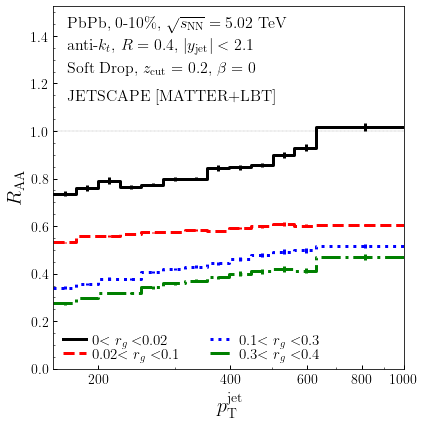

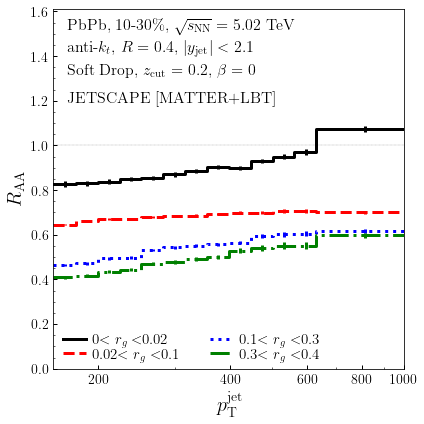

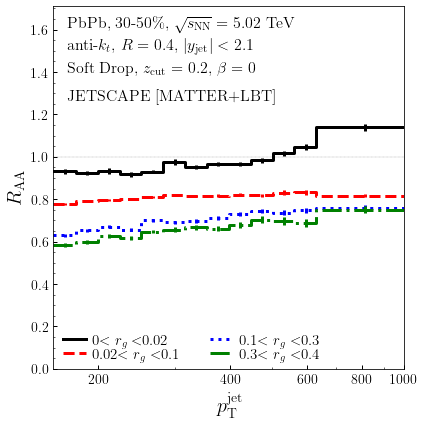

In [43]:
filename_pp = os.path.join(dataDir,'PP','PPMainResults',pt_1d_filename)
filename_aa = os.path.join(dataDir,'Q2QHAT','5020_PbPb_{}-{}_0.30_2.0_1MainResults', pt_1d_filename)
lines = [['black', 'solid'], ['red', 'dashed'],['blue','dotted'],['green','dashdot'],['magenta',(10, (5, 3, 1, 3, 1, 3))]]



copy_file_path = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/pbpb'
copy_file_path_raa = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/raa'
copy_file_path_pdf = '/Users/yasukitachibana/JETSCAPEDropbox/Data/ParentDataFolder/SubstructurePaper/ToATLAS/pt-dist/raa_plot'


plot_filename= os.path.join(dataDir,'Plots','plot_raa_pt_cent{}-{}.pdf')
# rg_bin_combine_here = [[0,14], [0,1], [1,7], [7,11], [11,13], [13,14]]
rg_bin_combine_here = [[1,7],[7,11],[11,13],[13,14]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_pt_cent{}-{}_1.pdf')
# rg_bin_combine_here = [[0,14],[0,1],[1,2],[2,3],[3,4]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_pt_cent{}-{}_2.pdf')
# rg_bin_combine_here = [[4,5],[5,6],[6,7],[7,8],[8,9]]

# plot_filename= os.path.join(dataDir,'Plots','plot_raa_pt_cent{}-{}_3.pdf')
# rg_bin_combine_here = [[9,10],[10,11],[11,12],[12,13],[13,14]]


cent = [ [['0','5'], ['5','10']], [['10','20'], ['20','30']], [['30','40'], ['40','50']] ] 



for c in cent:
  fig, axs = plt.subplots(1, 1, figsize=(6, 6))
  handles = []
  labels = []
  filename_cent = [] 

  for c_sub in c:
    filename_cent.append(filename_aa.format(c_sub[0], c_sub[1],'{}','{}'))
  
  ymax_plot = -1
  for i_data, k in enumerate(rg_bin_combine_here):

    rgl=rg_bin_finest[k[0]]
    rgh=rg_bin_finest[k[1]]



  

    # Get File name

    #PP 
    filename = filename_pp.format(str(int(10000*rgl)).zfill(4),str(int(10000*rgh)).zfill(4))
    x_pp, y_pp, err_pp, xstep_pp, ystep_pp = GetData1(filename)

    #AA
    filename = []
    for i_c_sub, c_sub in enumerate(c): 
      filename.append(filename_cent[i_c_sub].format(str(int(10000*rgl)).zfill(4),str(int(10000*rgh)).zfill(4)))
    x_aa, y_aa, err_aa, xstep_aa, ystep_aa = GetData2(filename[0],filename[1])

    copy_file_name = os.path.join(copy_file_path,'{}-{}'.format(c[0][0],c[-1][1]),os.path.basename(filename[0]))
    OutputData(copy_file_name, x_aa, y_aa, err_aa, xstep_aa, ystep_aa)



    x, y, err, xstep, ystep = GetDataRatio(x_aa, y_aa, err_aa, xstep_aa, ystep_aa, x_pp, y_pp, err_pp, xstep_pp, ystep_pp) 

    copy_file_name_raa = os.path.join(copy_file_path_raa,'{}-{}'.format(c[0][0],c[-1][1]),'raa_'+os.path.basename(filename[0]))
    OutputData(copy_file_name_raa, x, y, err, xstep, ystep)


    axs.step(xstep, ystep, where='post', color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)
    axs.errorbar(x, y, err, marker="", linestyle="none", color=lines[i_data][0], linewidth = 3)
    tcurve = axs.errorbar(0, 0, color=lines[i_data][0],linestyle=lines[i_data][1], linewidth = 3)

    if k[0] == 0:
      if k[1] == 1:
        labels.append('Soft Drop Failure')        
      else:
        labels.append('Inclusive')
    else:
      labels.append( '{:.1g}'.format(rgl)+r'$<r_g<$'+'{:.1g}'.format(rgh))
    handles.append(tcurve)


    ymax = max(y)
    if ymax_plot < ymax:
      ymax_plot = ymax


  ylim_h = ymax_plot*1.5
  ################
  axs.tick_params(labelsize = 14)
  axs.tick_params(width = 1, length = 4, pad=5)  
  axs.set_ylabel(r'$R_{\mathrm{AA}}$', fontsize=20, labelpad=6)
  axs.set_xlabel(r'$p^{\mathrm{jet}}_{\mathrm{T}}$', fontsize=20, labelpad=6)
  axs.set_xlim(158,1000)
  axs.set_ylim(0,ylim_h)  
  axs.set_xscale('log')
  #axs.ticklabel_format(style='plain', axis='x')

  axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
  axs.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter()) 
  axs.set_xticks([200,400,600,800,1000])


  
  # #axs.set_xticks([0.003,0.01,0.02,0.1,0.2,0.3])
  axs.label_outer()

  ################
  axs.text(170, ylim_h*0.94, r'PbPb, '+c[0][0]+'-'+c[-1][1]+'\%, '+r'$\sqrt{s_{\mathrm{NN}}}=5.02$ TeV', fontsize = 16, ha = 'left')
  axs.text(170, ylim_h*0.88, r'anti-$k_t$, $R=0.4$, $|y_{\mathrm{jet}}|<2.1$', fontsize = 16, ha = 'left')  
  axs.text(170, ylim_h*0.82, r'Soft Drop, $z_{\mathrm{cut}}=0.2$, $\beta=0$', fontsize = 16, ha = 'left')     

  axs.text(170, ylim_h*0.74, r'JETSCAPE [MATTER+LBT]', fontsize = 16, ha = 'left')     

  axs.legend(handles,labels,ncol=2,loc='lower left',edgecolor='none', frameon=True, facecolor='none', handletextpad=0.4, handleheight=0.5, labelspacing=0, bbox_to_anchor=(-0.01, -0.02), borderaxespad=0.5, handlelength=1.5, fontsize=15)
  axs.axhline(1, color = "black", linewidth=0.3, linestyle='dotted')

  # Generate PDF File
  pdf_filename = plot_filename.format(c[0][0],c[-1][1])
  print(pdf_filename)
  plt.tight_layout()
  plt.savefig(pdf_filename,transparent=True)
  shutil.copy(pdf_filename, os.path.join(copy_file_path_pdf,'{}-{}'.format(c[0][0],c[-1][1])))


  